## Downloding The Data Of FNO Stocks

In [5]:
import pandas as pd
data = pd.read_excel("FNOSymbols.xls")
data = data['Symbol']


In [ ]:
import yfinance as yf
for i in data:
    stock = yf.download(f"{i}.NS",interval="1d",start="2010-01-01")
    stock.to_csv(f"Data/{i}.csv")

## Identifing Reversal Pattern / Indicator Based On PIVOT BOSS Book

In [7]:
def topandbottombody(df):
    df['Reversal'] = "NO"
    for i in range(3,len(df)):
        rng = df['High'][i] - df['Low'][i]
        body_size = abs(df['Open'][i]-df['Close'][i])
        wick_size = rng - body_size

        bottom_35 = (rng*0.35) 
        top_35 = (rng*0.65) 

        if(wick_size/body_size >=2.5) and (min(df['Open'][i],df['Close'][i])>=(df['Low'][i]+top_35)) and df['Low'][i]<df['Low'][i-1]:
            df['Reversal'][i] = "Reversal"

    return df


In [8]:
from ta.momentum import RSIIndicator,StochRSIIndicator,StochasticOscillator
from ta.trend import EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
def Indicator(df):
    df['EMA_9'] = EMAIndicator(df['Close'], window=9).ema_indicator()
    df['EMA_20'] = EMAIndicator(df['Close'], window=20).ema_indicator()
    df['RSI'] = RSIIndicator(df['Close'],window=14).rsi()
    df['Stochastic'] = StochasticOscillator(df['High'], df['Low'], df['Close']).stoch()
    df['StochRSI'] = StochRSIIndicator(df['Close']).stochrsi()

    return df
   

In [ ]:
import os
import pandas as pd

data_folder = 'Data'
output_folder = "CalculatedData"

files = os.listdir(data_folder)

csv_files = [file for file in files if file.endswith('.csv')]

for csv_file in csv_files:
    file_path = os.path.join(data_folder, csv_file)
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)

    df = topandbottombody(df)
    df = Indicator(df)


    output_file_path = os.path.join(output_folder, f"processed_{csv_file}")
    
    df.to_csv(output_file_path, index=False)
    
    print(f"Saved processed file to: {output_file_path}")


## Brute BackTesting For Rules Define

In [26]:
def backtest(df,csv_file):
    df['Result']= ""
    trades = list([])
    for i in range(1,len(df)-1):
        if (df['Reversal'][i] == "Reversal" ):
            iscross = False
            entry_price = df['Open'][i+1] 
            re = -1
            tre = -1
            end = -1
            rng = df['High'][i] - df['Low'][i]
            body_size = abs(df['Open'][i]-df['Close'][i])
            wick_size = rng - body_size
            for j in range(i+2,len(df)):
                if(iscross == False and df['Close'][j]>=df['EMA_20'][j]) :
                    iscross = True
                if ((iscross and df['Close'][j] <= df['EMA_20'][j])) or df['Close'][j]<=df['Close'][i]*0.10 :
                    re = df['Close'][j] - entry_price
                    if(re < 0):
                        tre = 0
                    elif(re>0):
                        tre = 1
                    end = df['Date'][j]
                    break
            if(re != -1 and tre !=-1):
                trades.append({
                        'TradeType': "BullishReversal",
                        'TradeResult': tre,
                        'Result':re,
                        'EMA_9': df['EMA_9'][i],
                        'EMA_20': df['EMA_20'][i],
                        'RSI': df['RSI'][i],
                        'Name':csv_file,
                        'SDate':df['Date'][i],
                        'EDate':df['Date'][j],
                        "RatioB/W":(wick_size/body_size),
                        'StochasticRsi':df['StochRSI'][i],
                        "Stochastic":df['Stochastic'][i]
                    })
                re = -1
                tre = -1
    return trades

In [ ]:
import os
import pandas as pd

# Define the path to the data folder
data_folder = 'CalculatedData'

# List all files in the data folder
files = os.listdir(data_folder)

# Filter out only CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Loop through each CSV file and process it

mainn = []
for csv_file in csv_files:
    file_path = os.path.join(data_folder, csv_file)
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)


    result = backtest(df,csv_file)
    mainn.extend(result)


df = pd.DataFrame(mainn)
df.to_csv("result.csv")

In [ ]:
df

In [32]:
# Filter wins and losses based on TradeResult
wins = df[df['TradeResult'] > 0]
losses = df[df['TradeResult'] == 0]

# Calculate win statistics
total_wins = wins['Result'].sum()
average_win = wins['Result'].mean() if not wins.empty else 0

# Calculate loss statistics
total_losses = losses['Result'].sum()
average_loss = losses['Result'].mean() if not losses.empty else 0

# Calculate win rate
total_trades = len(df)
win_rate = (len(wins) / total_trades) * 100 if total_trades > 0 else 0

# Display results
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Wins: {total_wins:.2f}")
print(f"Average Win: {average_win:.2f}")
print(f"Average Loss: {average_loss:.2f}")
print(f"Profit factor Made : {(win_rate*average_win )- ((100-win_rate)*average_loss)}")
print(f"Profit RR Made : {(win_rate*average_win ) / ((100-win_rate)*average_loss*-1)}")

Win Rate: 49.11%
Total Wins: 649585.05
Average Win: 83.55
Average Loss: -54.09
Profit factor Made : 6855.409364089552
Profit RR Made : 1.4904485784470545


### By This Brute Force Method We Have : 1:1.42 Risk Return Ratio With Nearly 50% WinRate So By Default We Profitable But We Can FilterOut Signals By Some Indicator

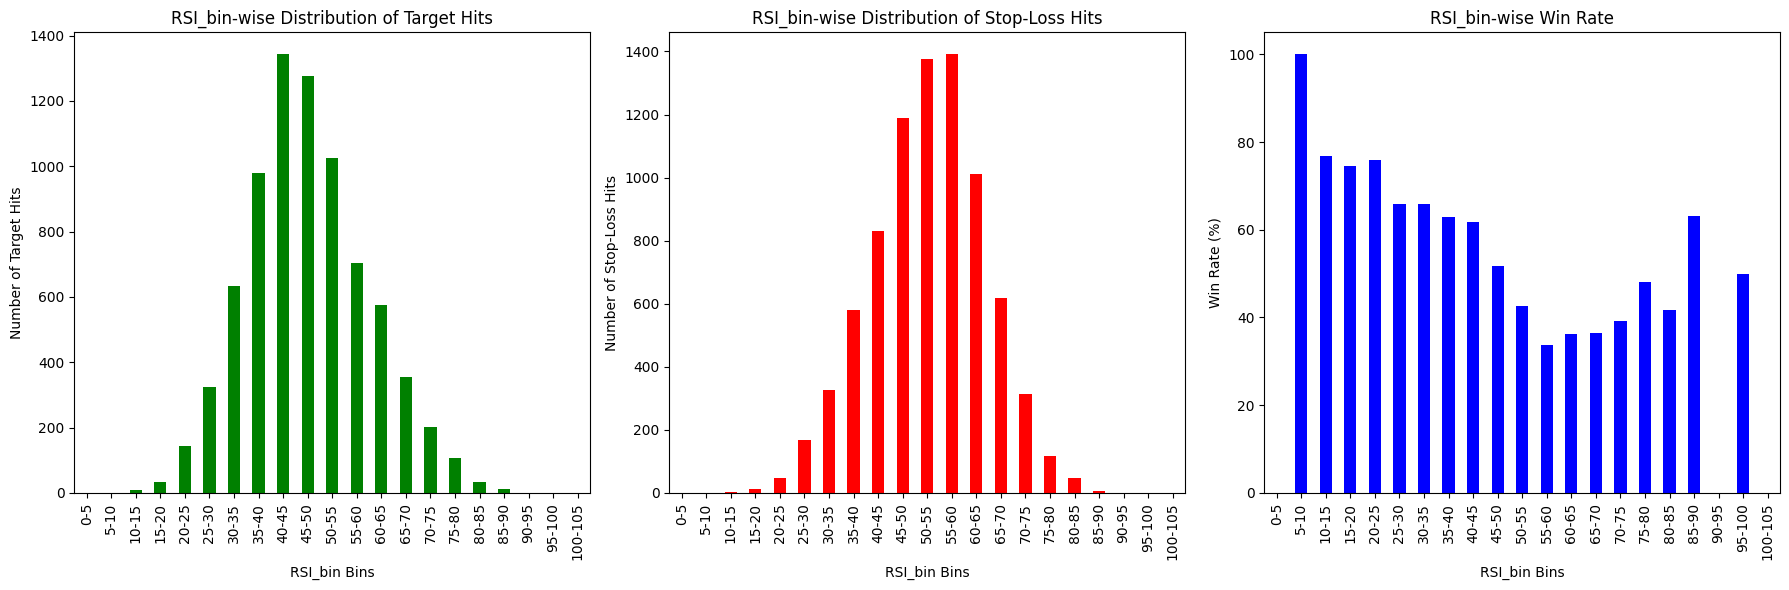

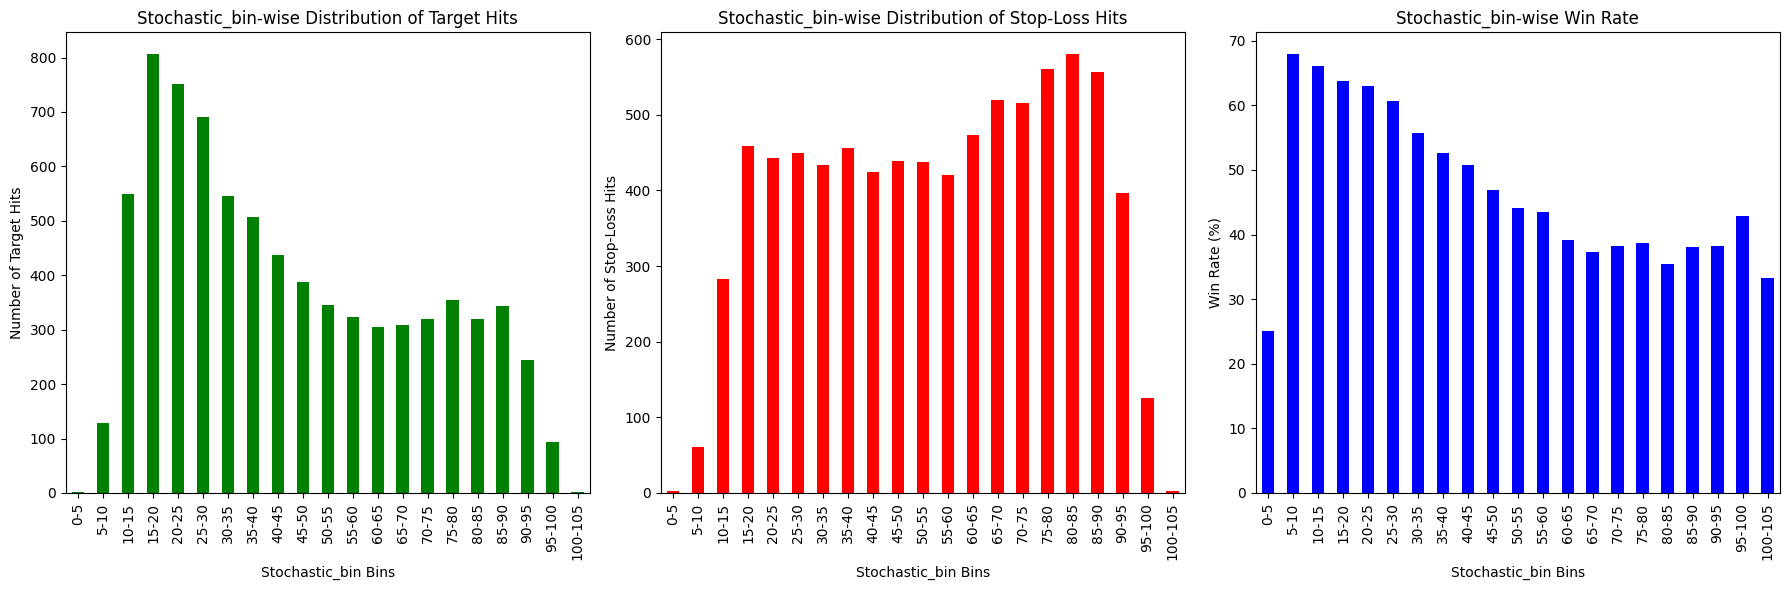

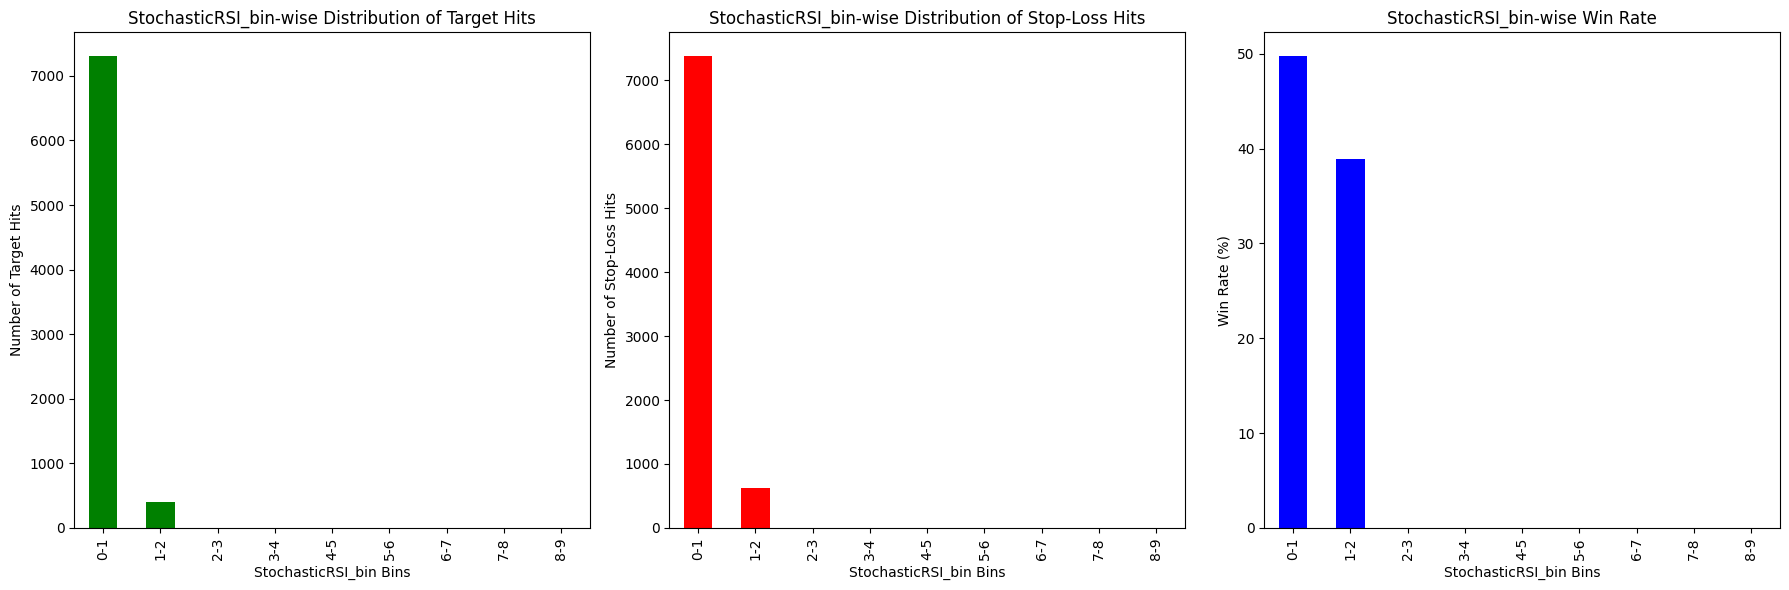

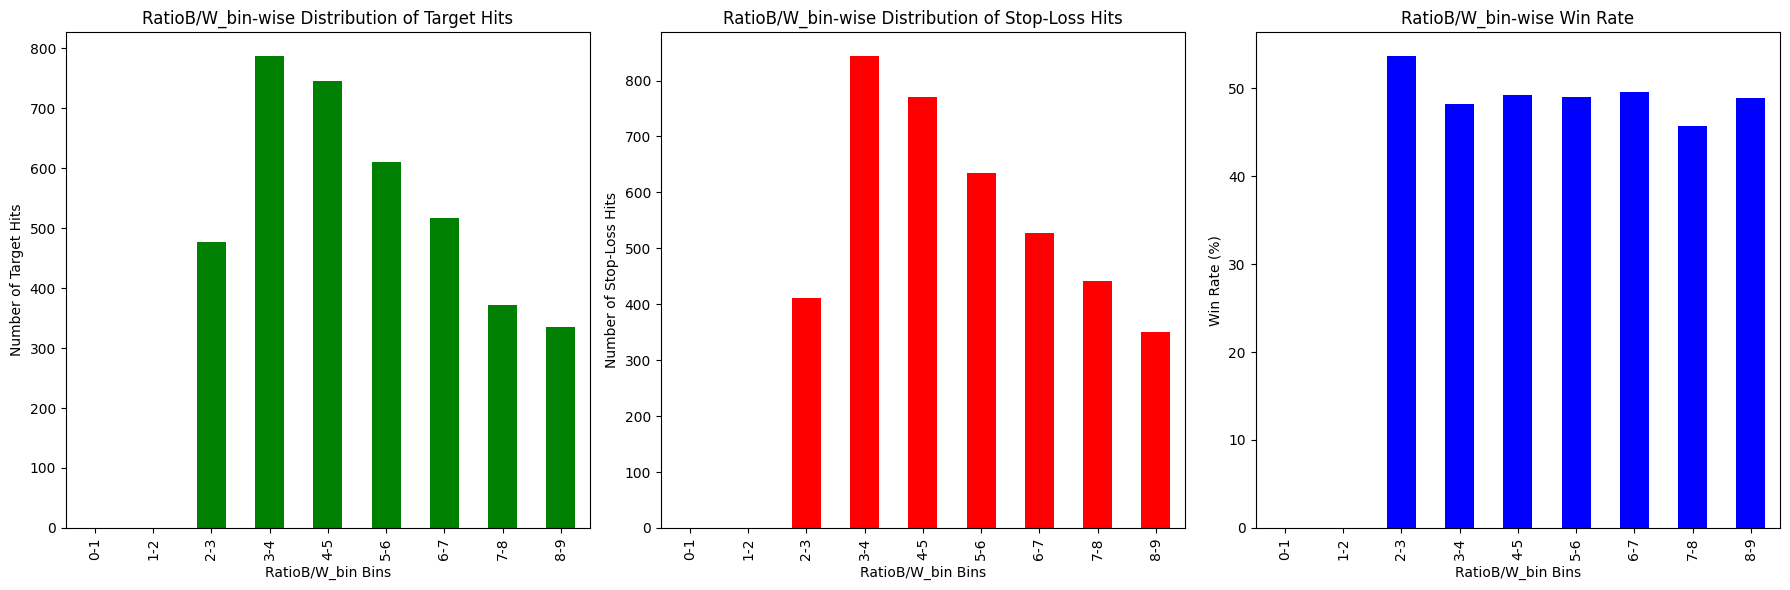

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df 

# Define bins and labels for each indicator
rsi_bins = range(0, 106, 5)  # RSI bins from 0 to 105 with intervals of 5
stochastic_bins = range(0, 106, 5)  # Stochastic bins from 0 to 105 with intervals of 5
stochasticrsi_bins = range(0, 10, 1)  # Stochastic RSI bins from 0 to 105 with intervals of 5
ratiobw_bins = range(0, 10, 1)  # RatioB/W bins with intervals of 5

rsi_labels = [f'{i}-{i+5}' for i in rsi_bins[:-1]]
stochastic_labels = [f'{i}-{i+5}' for i in stochastic_bins[:-1]]
stochasticrsi_labels = [f'{i}-{i+1}' for i in stochasticrsi_bins[:-1]]
ratiobw_labels = [f'{i}-{i+1}' for i in ratiobw_bins[:-1]]

# Create new columns for each indicator based on the bins
df['RSI_bin'] = pd.cut(df['RSI'], bins=rsi_bins, labels=rsi_labels, right=False)
df['Stochastic_bin'] = pd.cut(df['Stochastic'], bins=stochastic_bins, labels=stochastic_labels, right=False)
df['StochasticRSI_bin'] = pd.cut(df['StochasticRsi'], bins=stochasticrsi_bins, labels=stochasticrsi_labels, right=False)
df['RatioB/W_bin'] = pd.cut(df['RatioB/W'], bins=ratiobw_bins, labels=ratiobw_labels, right=False)

# Function to plot graphs for a given indicator
def plot_indicator(indicator_bin):
    target_hits = df[df['TradeResult'] == 1]
    stop_loss_hits = df[df['TradeResult'] == 0]

    target_hits_count = target_hits[indicator_bin].value_counts().sort_index()
    stop_loss_hits_count = stop_loss_hits[indicator_bin].value_counts().sort_index()

    total_trades_count = df[indicator_bin].value_counts().sort_index()

    win_rate = (target_hits_count / total_trades_count).fillna(0) * 100

    # Plotting the bar graphs
    plt.figure(figsize=(18, 6))

    # Plot for target hits
    plt.subplot(1, 3, 1)
    target_hits_count.plot(kind='bar', color='green')
    plt.title(f'{indicator_bin}-wise Distribution of Target Hits')
    plt.xlabel(f'{indicator_bin} Bins')
    plt.ylabel('Number of Target Hits')

    # Plot for stop-loss hits
    plt.subplot(1, 3, 2)
    stop_loss_hits_count.plot(kind='bar', color='red')
    plt.title(f'{indicator_bin}-wise Distribution of Stop-Loss Hits')
    plt.xlabel(f'{indicator_bin} Bins')
    plt.ylabel('Number of Stop-Loss Hits')

    # Plot for win rate
    plt.subplot(1, 3, 3)
    win_rate.plot(kind='bar', color='blue')
    plt.title(f'{indicator_bin}-wise Win Rate')
    plt.xlabel(f'{indicator_bin} Bins')
    plt.ylabel('Win Rate (%)')

    plt.tight_layout()
    plt.show()

# Plot graphs for each indicator
plot_indicator('RSI_bin')
plot_indicator('Stochastic_bin')
plot_indicator('StochasticRSI_bin')
plot_indicator('RatioB/W_bin')

### From This We Got Insight That By RSI <= 45 && STOCHASTICRSI <=45 WE GOT 60% WIN RATE BUT FIRST WE ANALYSE oNLY wITH Rsi

In [37]:
def backtest(df,csv_file):
    df['Result']= ""
    trades = list([])
    for i in range(1,len(df)-1):
        if (df['Reversal'][i] == "Reversal" ) and df['RSI'][i]<=45:
            iscross = False
            entry_price = df['Open'][i+1] 
            re = -1
            tre = -1
            end = -1
            rng = df['High'][i] - df['Low'][i]
            body_size = abs(df['Open'][i]-df['Close'][i])
            wick_size = rng - body_size
            for j in range(i+2,len(df)):
                if(iscross == False and df['Close'][j]>=df['EMA_20'][j]) :
                    iscross = True
                if ((iscross and df['Close'][j] <= df['EMA_20'][j])) or df['Close'][j]<=df['Close'][i]*0.10 :
                    re = df['Close'][j] - entry_price
                    if(re < 0):
                        tre = 0
                    elif(re>0):
                        tre = 1
                    end = df['Date'][j]
                    break
            if(re != -1 and tre !=-1):
                trades.append({
                        'TradeType': "BullishReversal",
                        'TradeResult': tre,
                        'Result':re,
                        'EMA_9': df['EMA_9'][i],
                        'EMA_20': df['EMA_20'][i],
                        'RSI': df['RSI'][i],
                        'Name':csv_file,
                        'SDate':df['Date'][i],
                        'EDate':df['Date'][j],
                        "RatioB/W":(wick_size/body_size),
                        'StochasticRsi':df['StochRSI'][i],
                        "Stochastic":df['Stochastic'][i]
                    })
                re = -1
                tre = -1
    return trades

In [ ]:
import os
import pandas as pd

# Define the path to the data folder
data_folder = 'CalculatedData'

# List all files in the data folder
files = os.listdir(data_folder)

# Filter out only CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Loop through each CSV file and process it

mainn = []
for csv_file in csv_files:
    file_path = os.path.join(data_folder, csv_file)
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)


    result = backtest(df,csv_file)
    mainn.extend(result)


df = pd.DataFrame(mainn)
df.to_csv("result.csv")

In [41]:
# Filter wins and losses based on TradeResult
wins = df[df['TradeResult'] > 0]
losses = df[df['TradeResult'] == 0]

# Calculate win statistics
total_wins = wins['Result'].sum()
average_win = wins['Result'].mean() if not wins.empty else 0

# Calculate loss statistics
total_losses = losses['Result'].sum()
average_loss = losses['Result'].mean() if not losses.empty else 0

# Calculate win rate
total_trades = len(df)
win_rate = (len(wins) / total_trades) * 100 if total_trades > 0 else 0

# Display results
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Wins: {total_wins:.2f}")
print(f"Average Win: {average_win:.2f}")
print(f"Average Loss: {average_loss:.2f}")
print(f"Profit factor Made : {(win_rate*average_win )- ((100-win_rate)*average_loss)}")
print(f"Profit RR Made : {(win_rate*average_win ) / ((100-win_rate)*average_loss*-1)}")

Win Rate: 63.82%
Total Wins: 216260.11
Average Win: 62.30
Average Loss: -66.87
347856.6321744919
Profit factor Made : 6395.599047150062
Profit RR Made : 1.6433574354974538


By Considerisng RSI <= 45 WE CAN GET 64% WIN RATE WITH RR RATIO OF 1.64

But Main Thing Is We Using Option Selling AS INstrument SO OVER LOSSES WILL BE LOWER AND WIN WILL INCRESED BECAUSE ODDS IS ON OUR FAVOR BECAUSE OF THETA DECAY SO THIS RISK RETURN EASYLY GO UP BY 1:2 OR 1:2.5 RETURNS AND WITH 64% WIN RATE

## WE BACKTESTING IN CASH BUYING SELLING NOT OPTION SO OPTION HAS EDGE WE GOT HIGH PROFIT BECAUSE OF THETA DECAY BUT WE NEED HOW MUCH PURE RUPPES WE GAIN SO THAT'S WHY DIRECT BUYING SELLING

In [42]:
def backtest(df,csv_file):
    df['Result']= ""
    trades = list([])
    for i in range(1,len(df)-1):
        if (df['Reversal'][i] == "Reversal" ) and df['RSI'][i]<=45:
            iscross = False
            entry_price = df['Open'][i+1]
            capital = 100000
            re = -1
            tre = -1
            end = -1
            rng = df['High'][i] - df['Low'][i]
            body_size = abs(df['Open'][i]-df['Close'][i])
            wick_size = rng - body_size
            for j in range(i+2,len(df)):
                if(iscross == False and df['Close'][j]>=df['EMA_20'][j]) :
                    iscross = True
                if ((iscross and df['Close'][j] <= df['EMA_20'][j])) or df['Close'][j]<=df['Close'][i]*0.10 :
                    re = (df['Close'][j] - entry_price) * (capital // entry_price)
                    if(re < 0):
                        tre = 0
                    elif(re>0):
                        tre = 1
                    end = df['Date'][j]
                    break
            if(re != -1 and tre !=-1):
                trades.append({
                        'TradeType': "BullishReversal",
                        'TradeResult': tre,
                        'Result':re,
                        'EMA_9': df['EMA_9'][i],
                        'EMA_20': df['EMA_20'][i],
                        'RSI': df['RSI'][i],
                        'Name':csv_file,
                        'SDate':df['Date'][i],
                        'EDate':df['Date'][j],
                        "RatioB/W":(wick_size/body_size),
                        'StochasticRsi':df['StochRSI'][i],
                        "Stochastic":df['Stochastic'][i]
                    })
                re = -1
                tre = -1
    return trades

In [ ]:
import os
import pandas as pd

# Define the path to the data folder
data_folder = 'CalculatedData'

# List all files in the data folder
files = os.listdir(data_folder)

# Filter out only CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Loop through each CSV file and process it

mainn = []
for csv_file in csv_files:
    file_path = os.path.join(data_folder, csv_file)
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)


    result = backtest(df,csv_file)
    mainn.extend(result)


df = pd.DataFrame(mainn)
df.to_csv("result.csv")

In [ ]:
df

In [64]:
# Filter wins and losses based on TradeResult
wins = df[df['TradeResult'] > 0]
losses = df[df['TradeResult'] == 0]

# Calculate win statistics
total_wins = wins['Result'].sum()
average_win = wins['Result'].mean() if not wins.empty else 0

# Calculate loss statistics
total_losses = losses['Result'].sum()
average_loss = losses['Result'].mean() if not losses.empty else 0

# Calculate win rate
total_trades = len(df)
win_rate = (len(wins) / total_trades) * 100 if total_trades > 0 else 0

# Display results
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Wins: {total_wins:.2f}")
print(f"TOTAL PNL(WIN RUPPES - LOSS RUPPES): {(total_wins-total_losses):.2f}")
print(f"Profit RR Made : {(win_rate*average_win ) / ((100-win_rate)*average_loss*-1)}")

Win Rate: 63.78%
Total Wins: 21665706.75
TOTAL PNL(WIN RUPPES - LOSS RUPPES): 33537611.42
Profit RR Made : 1.8249562595629285


In [66]:
# Given values
initial_capital = 1000000 # we taken each trade of 1 LAKH (10% OF CAPITAL) SO TOTAL WE HAVE 10LAKH SO WE CALCULATE RETURN ON 10 LAKH 
final_capital = 33637611.42
years = 15

# Calculate CAGR
cagr = (final_capital / initial_capital) ** (1 / years) - 1
print(f"CAGR: {cagr:.4f} or {cagr * 100:.2f}%") 

CAGR: 0.2641 or 26.41%


# BY THIS STRATAGY WE MADE 3.3 CR FROM ONLY 1 LAKH RUPPES

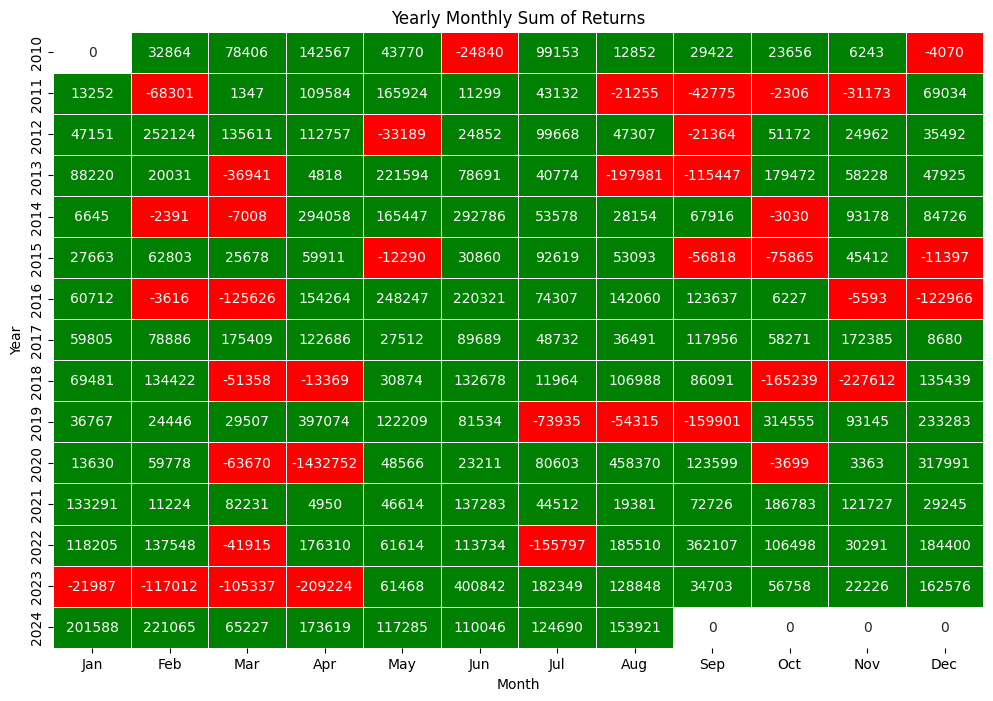

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df['EDate'] = pd.to_datetime(df['EDate'])

# Extract year and month from 'EDate'
df['Year'] = df['EDate'].dt.year
df['Month'] = df['EDate'].dt.month

monthly_returns = df.groupby(['Year', 'Month'])['Result'].sum().unstack(fill_value=0).astype(int)

monthly_returns.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

cmap = sns.color_palette(["red", "white", "green"])

norm = plt.Normalize(-1, 1)
normed_data = np.sign(monthly_returns)

plt.figure(figsize=(12, 8))
sns.heatmap(normed_data, annot=monthly_returns, fmt="d", cmap=cmap, linewidths=.5, center=0, cbar=False)

plt.title('Yearly Monthly Sum of Returns')
plt.xlabel('Month')
plt.ylabel('Year')

plt.show()